# Important Features Analysis for Meal Planning Dataset

This notebook analyzes the most important nutritional features in our food dataset to understand:

1. **Correlation patterns** between nutritional components
2. **Feature importance** for meal planning algorithms
3. **Statistical distributions** of nutritional values
4. **Principal components** that drive nutritional variance
5. **Clustering patterns** in food types

## Dataset Overview

We'll analyze the `final_usable_food_dataset.csv` which contains nutritional information for meal planning.


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
fig_size = (12, 8)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [3]:
# Load the dataset
df = pd.read_csv('../../dataset/process_dataset/final_usable_food_dataset.csv')

# Basic dataset information
print("📊 Dataset Overview")
print(f"Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print(f"\n📈 First 5 rows:")
print(df.head())

print(f"\n📋 Data Types:")
print(df.dtypes)

print(f"\n🔍 Missing Values:")
print(df.isnull().sum())

📊 Dataset Overview
Shape: (8681, 9)
Columns: ['food_item', 'calories', 'proteins', 'carbohydrates', 'fats', 'fibers', 'sugars', 'sodium', 'cholesterol']

📈 First 5 rows:
                                           food_item  calories  proteins  \
0                            2 minute noodle - Maggi     389.0       0.0   
1                     2-minute noodles - Maggi - 70g     389.0       2.0   
2  2-minutes masala noodles - Nestle nutrition - ...     389.0       8.2   
3                 3 Ingredient Peanut Butter Cookies      81.0       2.0   
4                      3-Ingredient Teriyaki Chicken     366.0      48.0   

   carbohydrates  fats  fibers  sugars   sodium  cholesterol  
0          59.60  13.5     2.0     1.8    2.571          0.0  
1           0.13  13.5     1.8    59.6    8.200         43.0  
2          59.60  13.5     2.0     1.8    1.028          0.0  
3           5.00   5.0     0.0     3.0  428.400         25.0  
4          20.00   9.0     0.0    17.0  237.200          2

In [4]:
# Define nutritional features (excluding food_item)
nutrition_features = ['calories', 'proteins', 'carbohydrates', 'fats', 'fibers', 'sugars', 'sodium', 'cholesterol']

# Statistical summary
print("📊 Statistical Summary of Nutritional Features")
print("=" * 60)
summary_stats = df[nutrition_features].describe()
print(summary_stats)

# Additional statistics
print(f"\n🎯 Key Insights:")
for feature in nutrition_features:
    mean_val = df[feature].mean()
    std_val = df[feature].std()
    cv = (std_val / mean_val) * 100 if mean_val != 0 else 0
    print(f"{feature:15}: Mean={mean_val:8.2f}, Std={std_val:8.2f}, CV={cv:6.1f}%")

📊 Statistical Summary of Nutritional Features
          calories      proteins  carbohydrates         fats       fibers  \
count  8681.000000   8681.000000    8681.000000  8681.000000  8681.000000   
mean    235.467060     17.203852      27.776551    10.896247     2.808566   
std     187.022727    708.348262     100.480303    17.818508     5.627945   
min       0.000000      0.000000       0.000000     0.000000     0.000000   
25%      82.000000      1.800000       3.300000     0.720000     0.000000   
50%     188.000000      6.200000      14.340000     4.600000     1.200000   
75%     367.000000     14.570000      50.700000    15.000000     3.100000   
max    2236.000000  66000.000000    9000.000000   646.000000    86.000000   

             sugars        sodium  cholesterol  
count   8681.000000   8681.000000  8681.000000  
mean      14.789015    317.418825    34.053836  
std      303.519749    957.645512   118.915129  
min        0.000000      0.000000     0.000000  
25%        0.43

## 1. Correlation Analysis

Let's analyze how different nutritional components correlate with each other. This helps us understand:

- Which nutrients tend to appear together
- Potential redundancy in features
- Natural groupings of nutritional components


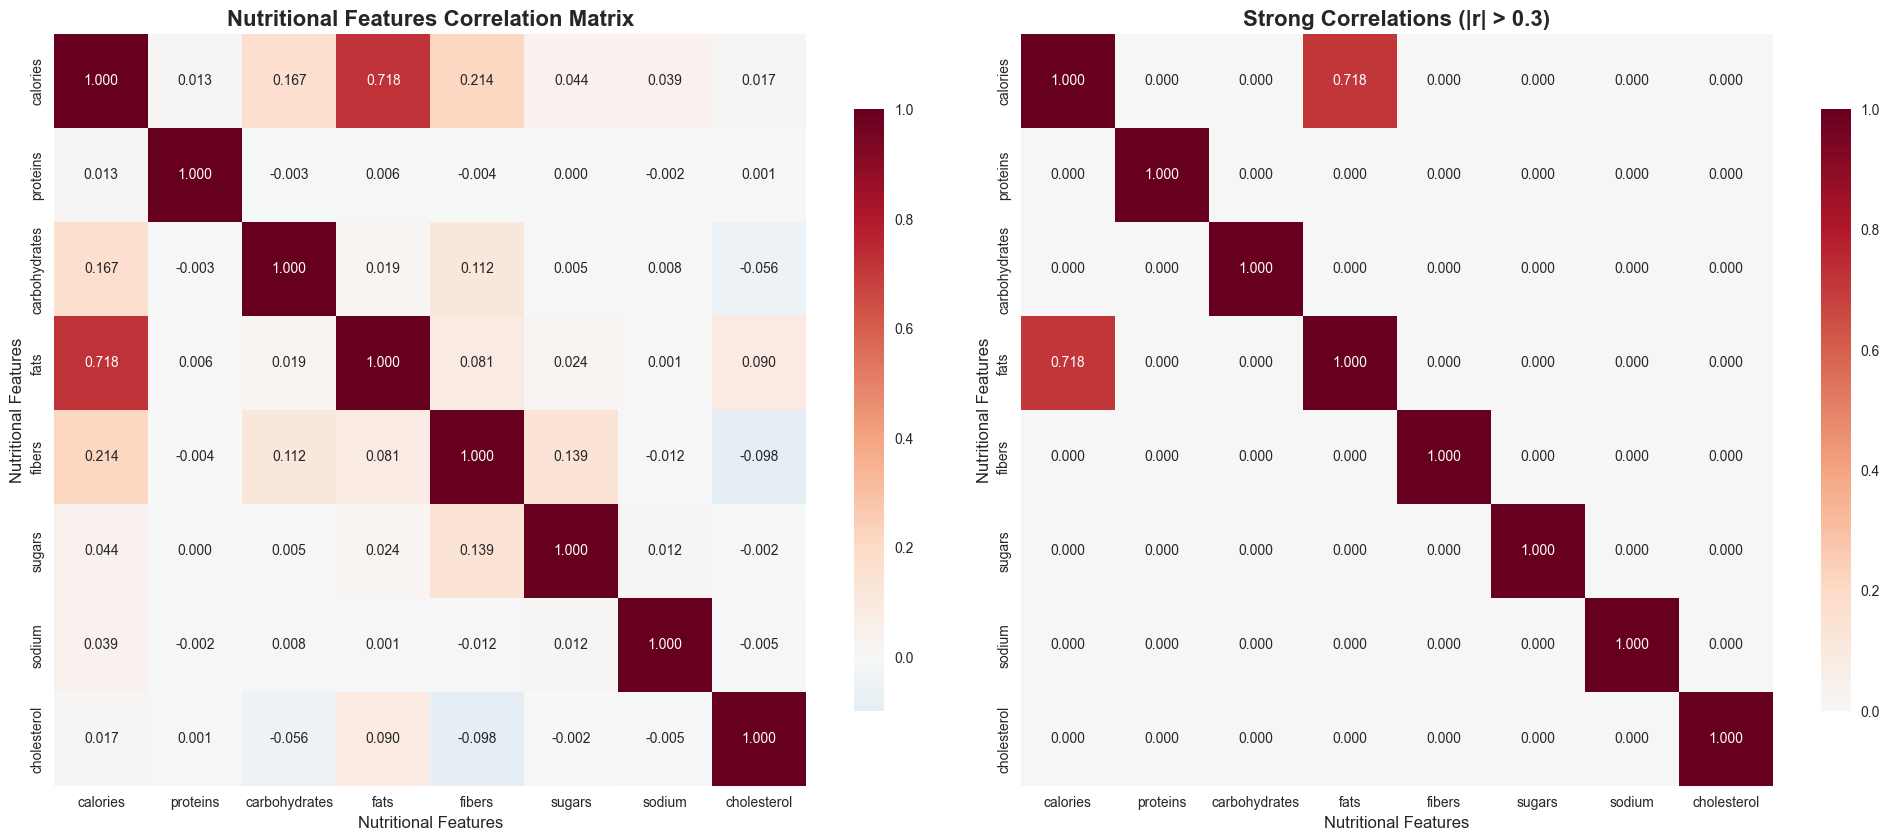

🔍 Strongest Correlations:
fats            ↔ calories       :  0.718
fibers          ↔ calories       :  0.214
carbohydrates   ↔ calories       :  0.167
sugars          ↔ fibers         :  0.139
fibers          ↔ carbohydrates  :  0.112


In [5]:
# Calculate correlation matrix
corr_matrix = df[nutrition_features].corr()

# Create correlation heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap 1: Full correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, 
            square=True, fmt='.3f', cbar_kws={'shrink': .8}, ax=ax1)
ax1.set_title('Nutritional Features Correlation Matrix', fontsize=16, fontweight='bold')
ax1.set_xlabel('Nutritional Features', fontsize=12)
ax1.set_ylabel('Nutritional Features', fontsize=12)

# Heatmap 2: Strong correlations only (|r| > 0.3)
strong_corr = corr_matrix.copy()
strong_corr[abs(strong_corr) < 0.3] = 0
sns.heatmap(strong_corr, annot=True, cmap='RdBu_r', center=0,
            square=True, fmt='.3f', cbar_kws={'shrink': .8}, ax=ax2)
ax2.set_title('Strong Correlations (|r| > 0.3)', fontsize=16, fontweight='bold')
ax2.set_xlabel('Nutritional Features', fontsize=12)
ax2.set_ylabel('Nutritional Features', fontsize=12)

plt.tight_layout()
plt.show()

# Print strongest correlations
print("🔍 Strongest Correlations:")
print("=" * 40)
# Get upper triangle of correlation matrix
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_pairs = corr_matrix.where(~mask).stack().sort_values(key=abs, ascending=False)

for i, (pair, corr_val) in enumerate(corr_pairs.head(10).items()):
    if abs(corr_val) > 0.1:  # Only show meaningful correlations
        print(f"{pair[0]:15} ↔ {pair[1]:15}: {corr_val:6.3f}")

## 2. Principal Component Analysis (PCA)

PCA helps us understand which combinations of nutritional features explain the most variance in our dataset. This identifies the most important "meta-features" that capture the essence of nutritional profiles.


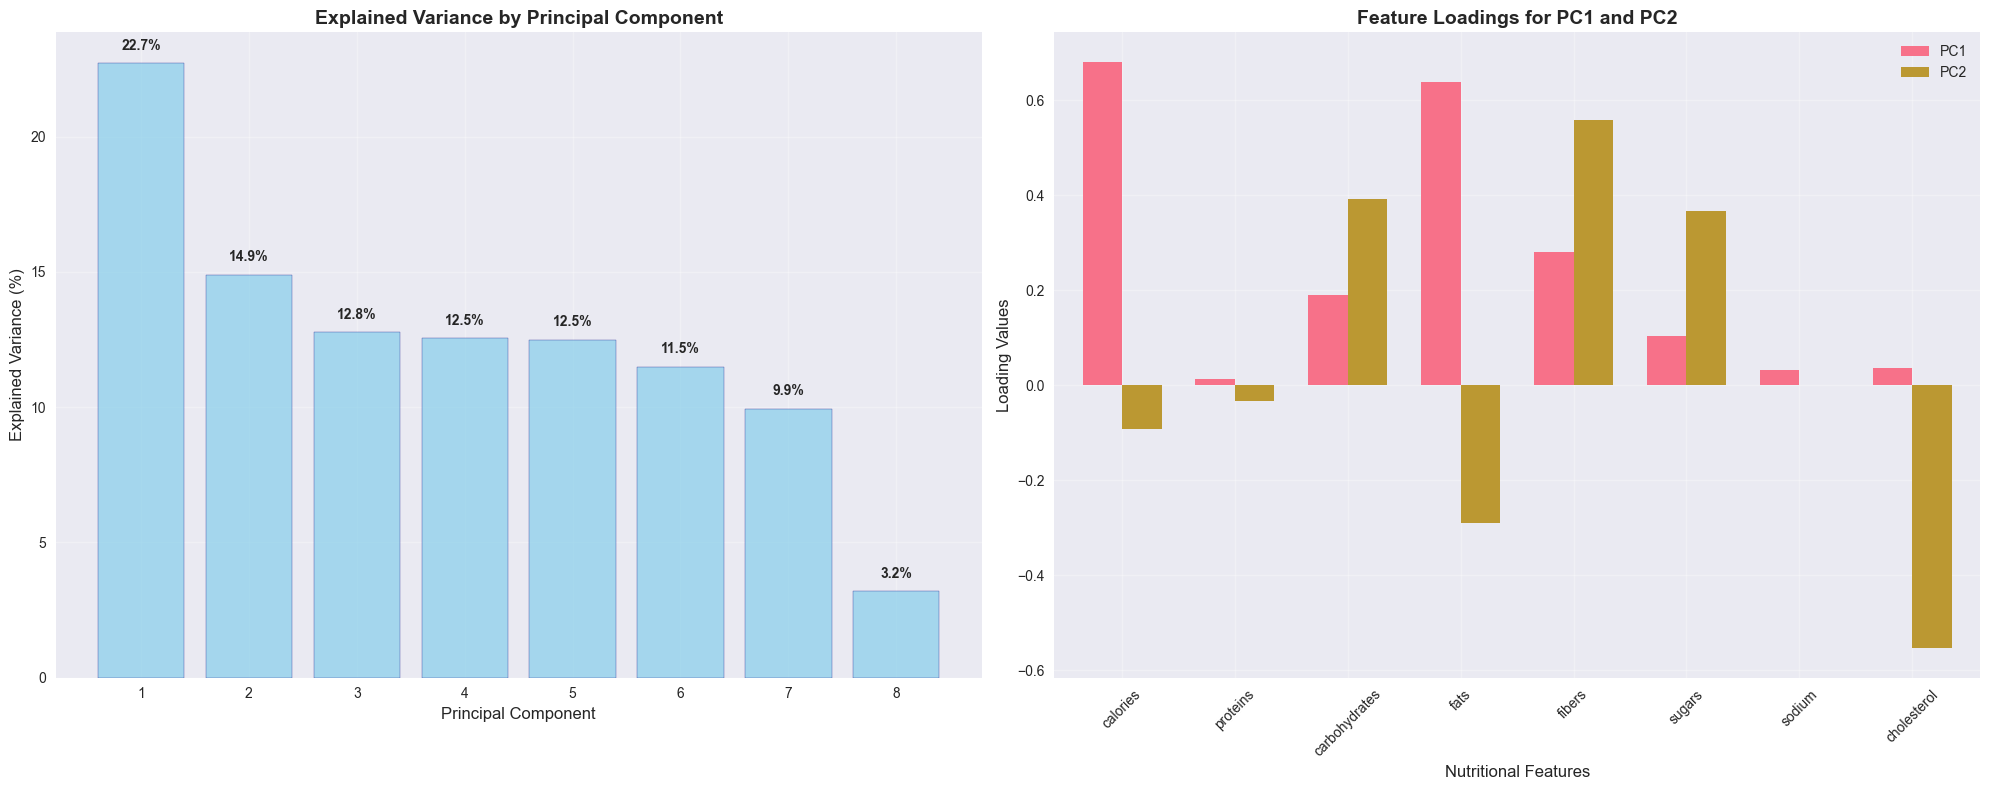

🎯 PCA Insights:
Components needed for 80% variance: 6
Components needed for 95% variance: 7

📊 Top 3 Components Explained Variance:
PC1: 22.72%
PC2: 14.89%
PC3: 12.77%

🔍 Most Important Features by Component:
PC1: calories(0.681), fats(0.638), fibers(0.281)
PC2: fibers(0.558), cholesterol(0.553), carbohydrates(0.392)
PC3: sugars(0.776), carbohydrates(0.477), cholesterol(0.359)


In [13]:
# Prepare data for PCA
X = df[nutrition_features].fillna(0)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

# Create PCA visualization - Only 1st and 3rd plots
fig, (ax1, ax3) = plt.subplots(1, 2, figsize=(20, 8))

# 1. Explained Variance by Component
ax1.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio * 100, 
        alpha=0.7, color='skyblue', edgecolor='navy')
ax1.set_xlabel('Principal Component', fontsize=12)
ax1.set_ylabel('Explained Variance (%)', fontsize=12)
ax1.set_title('Explained Variance by Principal Component', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
for i, v in enumerate(explained_variance_ratio * 100):
    ax1.text(i + 1, v + 0.5, f'{v:.1f}%', ha='center', fontweight='bold')

# 3. Feature Loadings for PC1 and PC2
loadings_df = pd.DataFrame(
    pca.components_[:2].T,
    columns=['PC1', 'PC2'],
    index=nutrition_features
)

loadings_df.plot(kind='bar', ax=ax3, width=0.7)
ax3.set_title('Feature Loadings for PC1 and PC2', fontsize=14, fontweight='bold')
ax3.set_xlabel('Nutritional Features', fontsize=12)
ax3.set_ylabel('Loading Values', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Print PCA insights
print("🎯 PCA Insights:")
print("=" * 50)
print(f"Components needed for 80% variance: {np.argmax(cumulative_variance >= 0.8) + 1}")
print(f"Components needed for 95% variance: {np.argmax(cumulative_variance >= 0.95) + 1}")
print(f"\n📊 Top 3 Components Explained Variance:")
for i in range(min(3, len(explained_variance_ratio))):
    print(f"PC{i+1}: {explained_variance_ratio[i]*100:.2f}%")

print(f"\n🔍 Most Important Features by Component:")
for i in range(min(3, len(pca.components_))):
    component_loadings = abs(pca.components_[i])
    top_features_idx = np.argsort(component_loadings)[::-1][:3]
    top_features = [nutrition_features[idx] for idx in top_features_idx]
    top_loadings = [component_loadings[idx] for idx in top_features_idx]
    print(f"PC{i+1}: {', '.join([f'{feat}({load:.3f})' for feat, load in zip(top_features, top_loadings)])}")

## 3. Feature Importance Analysis using Random Forest

We'll use Random Forest to determine which nutritional features are most important for predicting different target variables (like calories, which is often a key metric in meal planning).


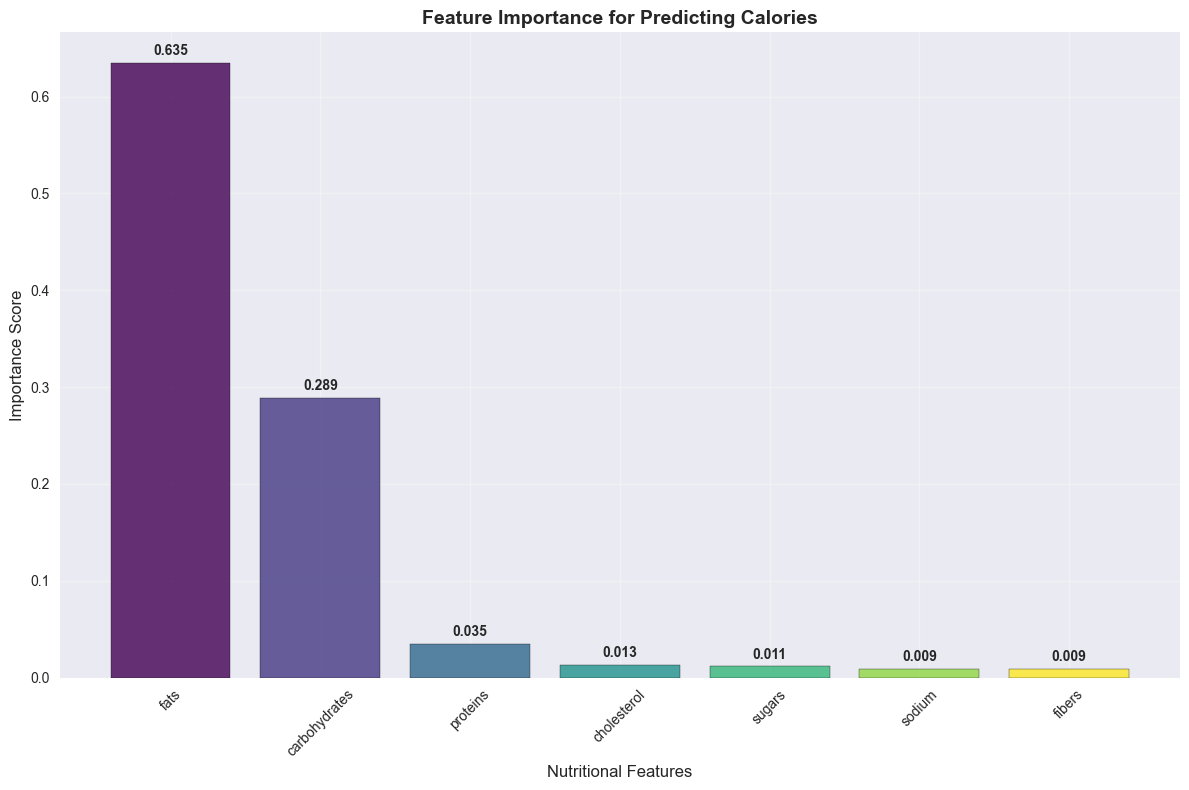

🎯 Feature Importance Insights:
Ranking for predicting Calories:
1. fats           : 0.6346
2. carbohydrates  : 0.2891
3. proteins       : 0.0348
4. cholesterol    : 0.0127
5. sugars         : 0.0114
6. sodium         : 0.0087
7. fibers         : 0.0086

Features needed for 80% importance: 2
Top features: fats, carbohydrates

Features needed for 90% importance: 2
Top features: fats, carbohydrates

Features needed for 95% importance: 3
Top features: fats, carbohydrates, proteins


In [14]:
# Feature importance analysis using Random Forest
# We'll predict calories based on other nutritional features

# Prepare features and target
feature_cols = [col for col in nutrition_features if col != 'calories']
X_rf = df[feature_cols].fillna(0)
y_rf = df['calories'].fillna(0)

# Train Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf.fit(X_rf, y_rf)

# Get feature importance
feature_importance = rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Create feature importance visualization - Only 1st plot
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

# Feature Importance Bar Plot
colors = plt.cm.viridis(np.linspace(0, 1, len(feature_importance_df)))
bars = ax1.bar(feature_importance_df['feature'], feature_importance_df['importance'], 
               color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('Feature Importance for Predicting Calories', fontsize=14, fontweight='bold')
ax1.set_xlabel('Nutritional Features', fontsize=12)
ax1.set_ylabel('Importance Score', fontsize=12)
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)

# Add value labels on bars
for bar, importance in zip(bars, feature_importance_df['importance']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{importance:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Print feature importance insights
print("🎯 Feature Importance Insights:")
print("=" * 50)
print("Ranking for predicting Calories:")
for i, (_, row) in enumerate(feature_importance_df.iterrows(), 1):
    print(f"{i}. {row['feature']:15}: {row['importance']:.4f}")

# Calculate cumulative importance for text output
cumulative_importance = np.cumsum(feature_importance_df['importance'])

# Calculate how many features needed for different thresholds
for threshold in [0.8, 0.9, 0.95]:
    n_features = np.argmax(cumulative_importance >= threshold) + 1
    print(f"\nFeatures needed for {threshold*100:.0f}% importance: {n_features}")
    top_features = feature_importance_df.head(n_features)['feature'].tolist()
    print(f"Top features: {', '.join(top_features)}")

## 4. Clustering Analysis

Let's identify natural groups of foods based on their nutritional profiles. This helps us understand food categories and can inform meal planning strategies.


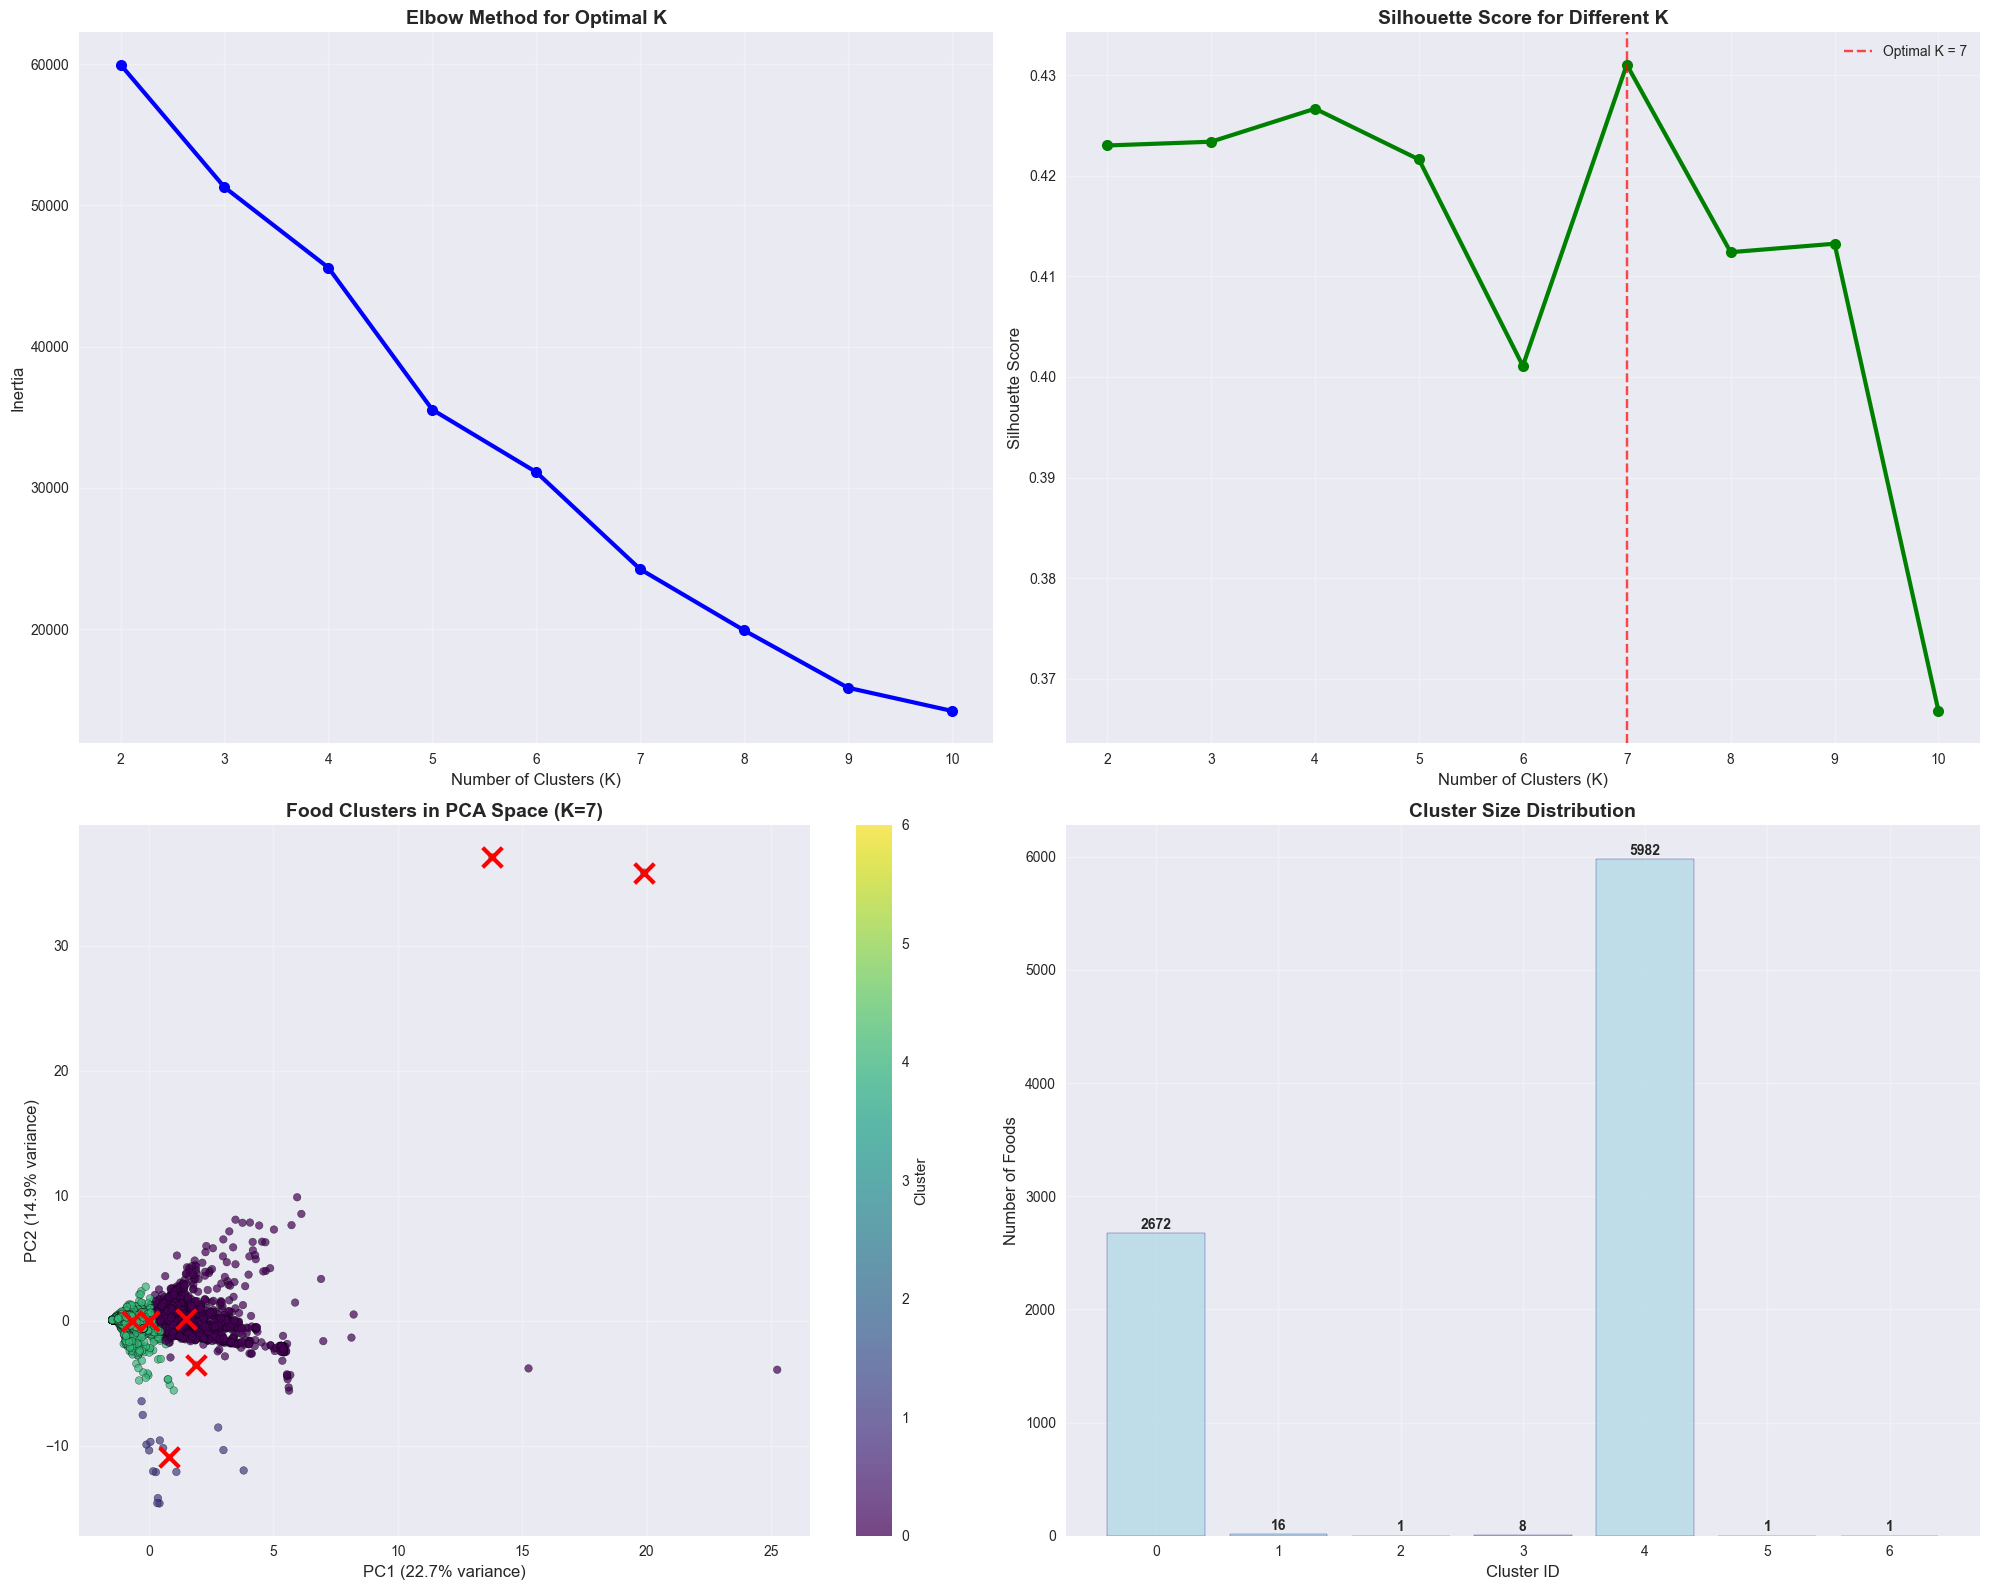

🎯 Cluster Analysis Results:
Optimal number of clusters: 7
Silhouette score: 0.431

📊 Cluster Characteristics (Mean Values):
         calories  proteins  carbohydrates   fats  fibers    sugars    sodium  \
cluster                                                                         
0          457.69     10.45          50.96  24.91    5.94     23.70    399.44   
1          244.38     18.06           0.42  18.55    0.00      2.74    178.50   
2          583.00      6.20        9000.00  38.00   15.50     27.00     30.00   
3          116.50      8.19          11.85   3.95    0.00      7.74  25880.38   
4          136.20      9.20          16.02   4.62    1.41      6.39    246.96   
5          410.00  66000.00           7.70  18.00    0.00      2.20     56.00   
6          543.00     55.30           0.10  31.40   58.50  26700.00    875.40   

         cholesterol  
cluster               
0              20.21  
1            2260.88  
2               0.00  
3               5.00  
4       

In [8]:
# Clustering analysis to identify food groups
# Prepare data for clustering
X_cluster = df[nutrition_features].fillna(0)
X_cluster_scaled = StandardScaler().fit_transform(X_cluster)

# Determine optimal number of clusters using elbow method and silhouette score
max_k = 10
inertias = []
silhouette_scores = []
K_range = range(2, max_k + 1)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_cluster_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster_scaled, cluster_labels))

# Find optimal k
optimal_k_silhouette = K_range[np.argmax(silhouette_scores)]

# Create clustering visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))

# 1. Elbow Method
ax1.plot(K_range, inertias, marker='o', linewidth=3, markersize=8, color='blue')
ax1.set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
ax1.set_xlabel('Number of Clusters (K)', fontsize=12)
ax1.set_ylabel('Inertia', fontsize=12)
ax1.grid(True, alpha=0.3)

# 2. Silhouette Score
ax2.plot(K_range, silhouette_scores, marker='o', linewidth=3, markersize=8, color='green')
ax2.axvline(x=optimal_k_silhouette, color='red', linestyle='--', alpha=0.7, 
           label=f'Optimal K = {optimal_k_silhouette}')
ax2.set_title('Silhouette Score for Different K', fontsize=14, fontweight='bold')
ax2.set_xlabel('Number of Clusters (K)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3)

# Perform final clustering with optimal k
final_kmeans = KMeans(n_clusters=optimal_k_silhouette, random_state=42, n_init=10)
cluster_labels = final_kmeans.fit_predict(X_cluster_scaled)

# 3. Clusters in PCA space
scatter = ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', 
                     alpha=0.7, s=30, edgecolors='black')
ax3.set_xlabel(f'PC1 ({explained_variance_ratio[0]*100:.1f}% variance)', fontsize=12)
ax3.set_ylabel(f'PC2 ({explained_variance_ratio[1]*100:.1f}% variance)', fontsize=12)
ax3.set_title(f'Food Clusters in PCA Space (K={optimal_k_silhouette})', fontsize=14, fontweight='bold')
plt.colorbar(scatter, ax=ax3, label='Cluster')
ax3.grid(True, alpha=0.3)

# Add cluster centers
centers_pca = pca.transform(final_kmeans.cluster_centers_)
ax3.scatter(centers_pca[:, 0], centers_pca[:, 1], c='red', marker='x', s=200, linewidths=3)

# 4. Cluster size distribution
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
ax4.bar(cluster_counts.index, cluster_counts.values, alpha=0.7, color='lightblue', edgecolor='navy')
ax4.set_title('Cluster Size Distribution', fontsize=14, fontweight='bold')
ax4.set_xlabel('Cluster ID', fontsize=12)
ax4.set_ylabel('Number of Foods', fontsize=12)
ax4.grid(True, alpha=0.3)

# Add value labels on bars
for i, count in enumerate(cluster_counts.values):
    ax4.text(i, count + 10, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Analyze cluster characteristics
df_with_clusters = df.copy()
df_with_clusters['cluster'] = cluster_labels

print("🎯 Cluster Analysis Results:")
print("=" * 60)
print(f"Optimal number of clusters: {optimal_k_silhouette}")
print(f"Silhouette score: {silhouette_scores[optimal_k_silhouette-2]:.3f}")

print("\n📊 Cluster Characteristics (Mean Values):")
cluster_means = df_with_clusters.groupby('cluster')[nutrition_features].mean()
print(cluster_means.round(2))

print("\n🔍 Representative Foods by Cluster:")
for cluster_id in range(optimal_k_silhouette):
    cluster_foods = df_with_clusters[df_with_clusters['cluster'] == cluster_id]
    print(f"\nCluster {cluster_id} ({len(cluster_foods)} foods):")
    
    # Show a few example foods
    sample_foods = cluster_foods['food_item'].head(5).tolist()
    print(f"Examples: {', '.join(sample_foods)}")
    
    # Show dominant nutritional characteristics
    cluster_mean = cluster_means.loc[cluster_id]
    top_nutrients = cluster_mean.nlargest(3)
    print(f"High in: {', '.join([f'{nutrient}({value:.1f})' for nutrient, value in top_nutrients.items()])}")

## 5. Nutritional Feature Distributions

Let's examine the distribution patterns of each nutritional feature to understand the range and spread of values in our dataset.


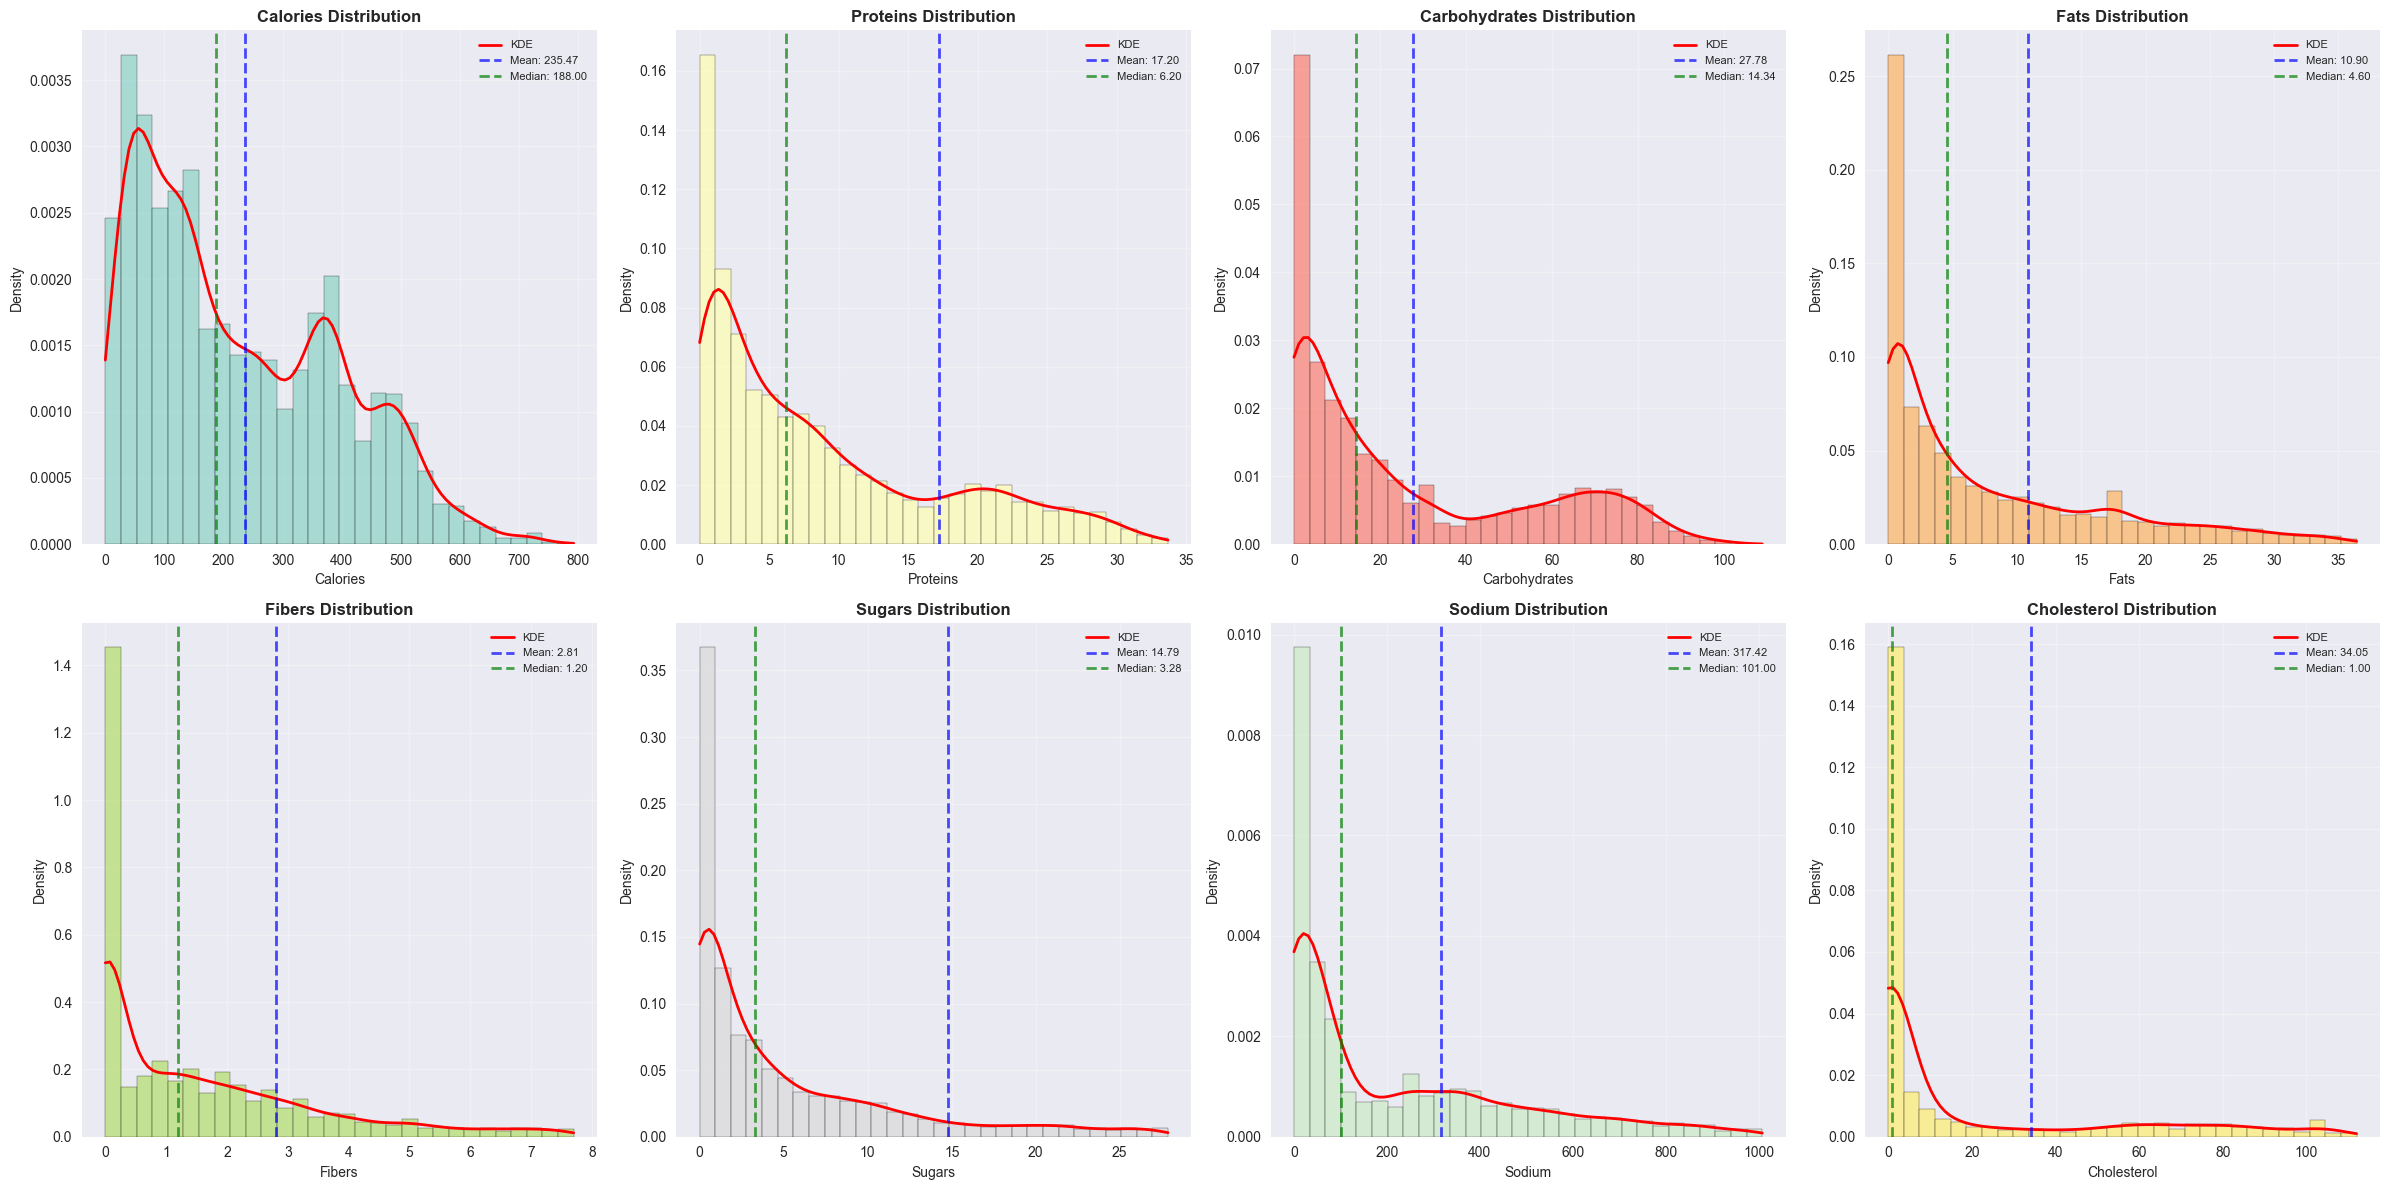

📊 Distribution Analysis Summary:
Feature         Mean     Median   Std      Skewness   Kurtosis  
----------------------------------------------------------------------
calories        235.47   188.00   187.02   1.28       4.17      
proteins        17.20    6.20     708.35   93.14      8676.92   
carbohydrates   27.78    14.34    100.48   82.07      7326.26   
fats            10.90    4.60     17.82    7.76       195.76    
fibers          2.81     1.20     5.63     6.26       58.07     
sugars          14.79    3.28     303.52   80.19      6918.26   
sodium          317.42   101.00   957.65   21.69      639.38    
cholesterol     34.05    1.00     118.92   15.08      303.44    

🚨 Outlier Analysis:
calories       :  132 outliers ( 1.52%)
                  Highest: Choco - Delhaize (2236.00)
                  Lowest: BABYFOOD,H2O,BTLD,GERBER,WO/ ADDED FLUORIDE. (0.00)
proteins       :  155 outliers ( 1.79%)
                  Highest: cake nuts and resins - britannia - 60g (66000.00)
 

In [9]:
# Distribution analysis of nutritional features
fig, axes = plt.subplots(2, 4, figsize=(24, 12))
axes = axes.ravel()

# Color palette for different features
colors = plt.cm.Set3(np.linspace(0, 1, len(nutrition_features)))

for i, feature in enumerate(nutrition_features):
    # Histogram with KDE
    ax = axes[i]
    
    # Remove outliers for better visualization
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter data
    filtered_data = df[feature][(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
    
    # Plot histogram
    ax.hist(filtered_data, bins=30, alpha=0.7, color=colors[i], edgecolor='black', density=True)
    
    # Add KDE
    try:
        from scipy import stats
        kde_data = np.linspace(filtered_data.min(), filtered_data.max(), 100)
        kde = stats.gaussian_kde(filtered_data.dropna())
        ax.plot(kde_data, kde(kde_data), color='red', linewidth=2, label='KDE')
    except:
        pass
    
    # Add statistics
    mean_val = df[feature].mean()
    median_val = df[feature].median()
    ax.axvline(mean_val, color='blue', linestyle='--', linewidth=2, alpha=0.7, label=f'Mean: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=2, alpha=0.7, label=f'Median: {median_val:.2f}')
    
    ax.set_title(f'{feature.title()} Distribution', fontsize=12, fontweight='bold')
    ax.set_xlabel(feature.title(), fontsize=10)
    ax.set_ylabel('Density', fontsize=10)
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical analysis of distributions
print("📊 Distribution Analysis Summary:")
print("=" * 70)
print(f"{'Feature':<15} {'Mean':<8} {'Median':<8} {'Std':<8} {'Skewness':<10} {'Kurtosis':<10}")
print("-" * 70)

for feature in nutrition_features:
    data = df[feature].dropna()
    mean_val = data.mean()
    median_val = data.median()
    std_val = data.std()
    skewness = data.skew()
    kurt = data.kurtosis()
    
    print(f"{feature:<15} {mean_val:<8.2f} {median_val:<8.2f} {std_val:<8.2f} {skewness:<10.2f} {kurt:<10.2f}")

# Identify outliers
print("\n🚨 Outlier Analysis:")
print("=" * 50)
for feature in nutrition_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    outlier_percentage = (len(outliers) / len(df)) * 100
    
    print(f"{feature:<15}: {len(outliers):>4} outliers ({outlier_percentage:>5.2f}%)")
    
    if len(outliers) > 0:
        # Show extreme outliers
        extreme_high = df[df[feature] == df[feature].max()]['food_item'].iloc[0]
        extreme_low = df[df[feature] == df[feature].min()]['food_item'].iloc[0]
        print(f"{'':>17} Highest: {extreme_high} ({df[feature].max():.2f})")
        print(f"{'':>17} Lowest: {extreme_low} ({df[feature].min():.2f})")

## 6. Summary and Recommendations

Based on our comprehensive analysis, let's summarize the key findings and provide recommendations for meal planning algorithms.


In [10]:
# Summary Analysis and Recommendations
print("" * 80)
print("🎯 IMPORTANT FEATURES ANALYSIS - SUMMARY REPORT")
print("" * 80)

# 1. Most Important Features Summary
print("\n1️⃣ MOST IMPORTANT NUTRITIONAL FEATURES:")
print("=" * 50)
top_3_features = feature_importance_df.head(3)
for i, (_, row) in enumerate(top_3_features.iterrows(), 1):
    importance_pct = row['importance'] * 100
    print(f"{i}. {row['feature'].upper():<15}: {importance_pct:>6.2f}% importance")

# 2. Principal Components Summary
print("\n2️⃣ KEY NUTRITIONAL DIMENSIONS (PCA):")
print("=" * 50)
for i in range(min(3, len(pca.components_))):
    variance_pct = explained_variance_ratio[i] * 100
    component_loadings = abs(pca.components_[i])
    top_feature_idx = np.argmax(component_loadings)
    top_feature = nutrition_features[top_feature_idx]
    print(f"PC{i+1}: {variance_pct:>6.2f}% variance - Driven by {top_feature.upper()}")

# 3. Correlation Insights
print("\n3️⃣ KEY NUTRITIONAL RELATIONSHIPS:")
print("=" * 50)
# Find strongest positive and negative correlations
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
corr_pairs = corr_matrix.where(~mask).stack()
strongest_pos = corr_pairs.nlargest(3)
strongest_neg = corr_pairs.nsmallest(3)

print("Strongest Positive Correlations:")
for (feat1, feat2), corr_val in strongest_pos.items():
    if corr_val > 0.1:
        print(f"  • {feat1.upper()} ↔ {feat2.upper()}: {corr_val:.3f}")

print("Strongest Negative Correlations:")
for (feat1, feat2), corr_val in strongest_neg.items():
    if corr_val < -0.1:
        print(f"  • {feat1.upper()} ↔ {feat2.upper()}: {corr_val:.3f}")

# 4. Clustering Insights
print("\n4️⃣ FOOD GROUPINGS:")
print("=" * 50)
print(f"Optimal number of food clusters: {optimal_k_silhouette}")
print(f"Clustering quality (silhouette score): {silhouette_scores[optimal_k_silhouette-2]:.3f}")

# Identify cluster characteristics
for cluster_id in range(optimal_k_silhouette):
    cluster_size = len(df_with_clusters[df_with_clusters['cluster'] == cluster_id])
    cluster_mean = cluster_means.loc[cluster_id]
    dominant_nutrient = cluster_mean.idxmax()
    dominant_value = cluster_mean.max()
    
    print(f"  • Cluster {cluster_id}: {cluster_size} foods - High in {dominant_nutrient.upper()} ({dominant_value:.1f})")

# 5. Data Quality Insights
print("\n5️⃣ DATA QUALITY INSIGHTS:")
print("=" * 50)
print(f"Total food items: {len(df):,}")
print(f"Complete records: {len(df.dropna()):,} ({len(df.dropna())/len(df)*100:.1f}%)")

# Features with most outliers
outlier_counts = {}
for feature in nutrition_features:
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[feature] < Q1 - 1.5*IQR) | (df[feature] > Q3 + 1.5*IQR)]
    outlier_counts[feature] = len(outliers)

most_outliers = max(outlier_counts, key=outlier_counts.get)
print(f"Feature with most outliers: {most_outliers.upper()} ({outlier_counts[most_outliers]} outliers)")

# 6. Recommendations
print("\n6️⃣ RECOMMENDATIONS FOR MEAL PLANNING:")
print("=" * 50)
print("✅ PRIORITIZE these features in your algorithms:")
for i, (_, row) in enumerate(feature_importance_df.head(4).iterrows(), 1):
    print(f"   {i}. {row['feature'].upper()} (importance: {row['importance']:.3f})")

print("\n✅ DIMENSIONALITY REDUCTION:")
components_80 = np.argmax(cumulative_variance >= 0.8) + 1
components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"   • Use {components_80} components for 80% variance capture")
print(f"   • Use {components_95} components for 95% variance capture")

print("\n✅ FOOD CATEGORIZATION:")
print(f"   • Use {optimal_k_silhouette} clusters for food grouping")
print(f"   • Cluster-based meal selection can improve variety")

print("\n✅ DATA PREPROCESSING:")
high_variance_features = [f for f in nutrition_features if df[f].std()/df[f].mean() > 1.0]
print(f"   • Consider log transformation for: {', '.join([f.upper() for f in high_variance_features])}")
print(f"   • Standard scaling recommended for all features")

print("\n✅ FEATURE ENGINEERING:")
print("   • Create macro ratios: protein/carb ratio, fat percentage")
print("   • Nutritional density scores: nutrients per calorie")
print("   • Balanced meal scores based on target distributions")

print("\n" + "" * 80)
print("📊 Analysis Complete! Use these insights to optimize your meal planning algorithms.")
print("" * 80)

# Save important features for future use
important_features_summary = {
    'top_features': feature_importance_df.head(5).to_dict('records'),
    'pca_components_80_percent': components_80,
    'pca_components_95_percent': components_95,
    'optimal_clusters': optimal_k_silhouette,
    'strong_correlations': [(pair[0], pair[1], corr_val) for pair, corr_val in corr_pairs.items() if abs(corr_val) > 0.5],
    'high_variance_features': high_variance_features
}

print(f"\n💾 Summary saved for future reference.")
print(f"Key findings: {len(important_features_summary)} categories analyzed")


🎯 IMPORTANT FEATURES ANALYSIS - SUMMARY REPORT


1️⃣ MOST IMPORTANT NUTRITIONAL FEATURES:
1. FATS           :  63.46% importance
2. CARBOHYDRATES  :  28.91% importance
3. PROTEINS       :   3.48% importance

2️⃣ KEY NUTRITIONAL DIMENSIONS (PCA):
PC1:  22.72% variance - Driven by CALORIES
PC2:  14.89% variance - Driven by FIBERS
PC3:  12.77% variance - Driven by SUGARS

3️⃣ KEY NUTRITIONAL RELATIONSHIPS:
Strongest Positive Correlations:
  • FATS ↔ CALORIES: 0.718
  • FIBERS ↔ CALORIES: 0.214
  • CARBOHYDRATES ↔ CALORIES: 0.167
Strongest Negative Correlations:

4️⃣ FOOD GROUPINGS:
Optimal number of food clusters: 7
Clustering quality (silhouette score): 0.431
  • Cluster 0: 2672 foods - High in CALORIES (457.7)
  • Cluster 1: 16 foods - High in CHOLESTEROL (2260.9)
  • Cluster 2: 1 foods - High in CARBOHYDRATES (9000.0)
  • Cluster 3: 8 foods - High in SODIUM (25880.4)
  • Cluster 4: 5982 foods - High in SODIUM (247.0)
  • Cluster 5: 1 foods - High in PROTEINS (66000.0)
  • Cluster 6: 1